### Follow Gaze Patterns in Children With Autism Spectrum Disorder to Emotional Faces: Scanpath and Similarit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import RobustScaler, StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2


In [2]:
# ======================================================
# 1. CHUẨN BỊ DỮ LIỆU ĐA BIẾN (ĐÃ TÍCH HỢP AOI)
# ======================================================
try:
    df = pd.read_csv('original_file.csv')
    print("Đã đọc file.")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'original_file.csv'")
    exit()

# --- BƯỚC 1: TÍNH TOÁN AOI TRƯỚC KHI PIVOT ---

# BẠN CẦN ĐẢM BẢO RẰNG CÁC TỌA ĐỘ NÀY ĐÚNG VỚI ẢNH CỦA BẠN
AOI_EYES_X = 512; AOI_EYES_Y = 350
AOI_MOUTH_X = 512; AOI_MOUTH_Y = 550

# Tính khoảng cách mới (Đặc trưng được áp dụng từ nghiên cứu)
df['DIST_EYES'] = np.sqrt((df['FIX_X'] - AOI_EYES_X)**2 + (df['FIX_Y'] - AOI_EYES_Y)**2)
df['DIST_MOUTH'] = np.sqrt((df['FIX_X'] - AOI_MOUTH_X)**2 + (df['FIX_Y'] - AOI_MOUTH_Y)**2)

# Hàm hỗ trợ Pivot đã được sửa lại thứ tự lấp đầy
def pivot_feature(df, value_col):
    df_pivoted = df.pivot_table(
        index=['numeric_id', 'image_id', 'label'],
        columns='FIX_INDEX',
        values=value_col
    ).reset_index()

    step_cols = [i for i in range(1, 21)]

    # --- SỬA LOGIC: bfill() trước, ffill() sau ---
    # 1. bfill(axis=1): Lấp đầy các NaNs từ cuối chuỗi (giúp lấp các NaNs ở đầu)
    # 2. ffill(axis=1): Lấp đầy các NaNs còn sót lại
    df_pivoted[step_cols] = df_pivoted[step_cols].bfill(axis=1).ffill(axis=1)

    return df_pivoted, df_pivoted[step_cols].values

print("Đang xử lý 4 đặc trưng (Pupil, Duration, Dist_Eyes, Dist_Mouth)...")

# --- 2. PIVOT CÁC ĐẶC TRƯNG MỚI (CHÍNH LÀ ĐOẠN BẠN CẦN SỬA) ---

# Xử lý PUPIL (Có Baseline Correction)
df_meta, pupil_values = pivot_feature(df, 'FIX_PUPIL')
pupil_baseline = pupil_values[:, 0].reshape(-1, 1) 
pupil_values = pupil_values - pupil_baseline 

# Xử lý DURATION (Giữ nguyên)
_, dur_values = pivot_feature(df, 'FIX_DURATION')

# SỬA: Pivot các cột khoảng cách AOI mới thay vì X, Y thô
_, deye_values = pivot_feature(df, 'DIST_EYES') # <--- ĐÃ THAY THẾ
_, dmou_values = pivot_feature(df, 'DIST_MOUTH') # <--- ĐÃ THAY THẾ

# --- 3. GỘP TẤT CẢ THÀNH KHỐI 3D (STACKING) ---
X_combined = np.stack([pupil_values, dur_values, deye_values, dmou_values], axis=2)

print(f"Kích thước dữ liệu đầu vào: {X_combined.shape}")
print(f"Kiểm tra: Shape phải có 4 đặc trưng. ({X_combined.shape[0]}, 20, 4)")

# Lấy nhãn và ID (Không thay đổi)
y_all = df_meta['label'].values
ids_all = df_meta['numeric_id'].values

Đã đọc file.
Đang xử lý 4 đặc trưng (Pupil, Duration, Dist_Eyes, Dist_Mouth)...
Kích thước dữ liệu đầu vào: (15912, 20, 4)
Kiểm tra: Shape phải có 4 đặc trưng. (15912, 20, 4)


In [3]:
# ======================================================
# 2. CHIA TRAIN/TEST (STRATIFIED)
# ======================================================
# Lấy danh sách ID duy nhất để chia
patients_info = df_meta[['numeric_id', 'label']].drop_duplicates()
unique_patients = patients_info['numeric_id'].values
patient_labels = patients_info['label'].values 

train_ids, test_ids = train_test_split(
    unique_patients, 
    test_size=0.2, 
    random_state=42, 
    stratify=patient_labels 
)

# Tạo mask để lọc dữ liệu
train_mask = np.isin(ids_all, train_ids)
test_mask = np.isin(ids_all, test_ids)

X_train = X_combined[train_mask]
y_train = y_all[train_mask]
ids_test = ids_all[test_mask] # Giữ lại ID tập test để đánh giá sau
X_test = X_combined[test_mask]
y_test = y_all[test_mask]

In [4]:
# ======================================================
# 3. CHUẨN HÓA DỮ LIỆU (SCALING RIÊNG LẺ)
# ======================================================
# Vì Pupil đơn vị là 1000, Duration là 100, X/Y là tọa độ -> Phải scale riêng từng kênh
print("Đang chuẩn hóa dữ liệu (RobustScaler)...")

scalers = {} # Lưu scaler cho từng kênh để dùng lại nếu cần
for i in range(4): # 4 kênh: 0=Pupil, 1=X, 2=Y, 3=Duration
    scaler = RobustScaler()
    # Fit trên tập train, transform trên cả train và test
    # Lưu ý: fit_transform nhận đầu vào 2D, nên ta giữ nguyên (N, 20) của từng kênh để scale
    X_train[:, :, i] = scaler.fit_transform(X_train[:, :, i])
    X_test[:, :, i] = scaler.transform(X_test[:, :, i])
    scalers[i] = scaler
print("Chuẩn hóa xong.")

Đang chuẩn hóa dữ liệu (RobustScaler)...
Chuẩn hóa xong.


In [13]:
# ======================================================
# 4. XÂY DỰNG MÔ HÌNH (BIDIRECTIONAL GRU) - ĐÃ TINH CHỈNH LR
# ======================================================
model = Sequential()

# Input Shape (20, 4) - Chuẩn cho 4 đặc trưng mới (Pupil, Duration, D_Eyes, D_Mouth)
model.add(Bidirectional(GRU(16, return_sequences=True), input_shape=(20, 4)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Bidirectional(GRU(8, return_sequences=False)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Lớp Dense (Hidden Layer)
model.add(Dense(4, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())

# Lớp Output
model.add(Dense(1, activation='sigmoid'))

# Callbacks (Độ kiên nhẫn lớn để học kỹ)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# COMPILE: Áp dụng Learning Rate theo khuyến nghị bài báo
model.compile(optimizer=Adam(learning_rate=0.0001), # <-- SỬA: Giảm Learning Rate 10 lần
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 20, 32)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 20, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 16)             │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,409 (17.22 KB)

 Trainable params: 4,305 (16.82 KB)

 Non-trainable params: 104 (416.00 B)

In [14]:
# ======================================================
# 5. HUẤN LUYỆN
# ======================================================
print("\n Bắt đầu huấn luyện...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


 Bắt đầu huấn luyện...
Epoch 1/100


80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5149 - loss: 0.9444 - val_accuracy: 0.1443 - val_loss: 0.9037 - learning_rate: 1.0000e-04
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5429 - loss: 0.8712 - val_accuracy: 0.1647 - val_loss: 1.0294 - learning_rate: 1.0000e-04
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5704 - loss: 0.8190 - val_accuracy: 0.2673 - val_loss: 1.0090 - learning_rate: 1.0000e-04
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5951 - loss: 0.7790 - val_accuracy: 0.3550 - val_loss: 0.9403 - learning_rate: 1.0000e-04
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6080 - loss: 0.7428 - val_accuracy: 0.4210 - val_loss: 0.8821 - learning_rate: 1.0000e-04
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6182 - loss: 0.7294 - val_accuracy: 0.4583 - val_loss: 0.8492 - learning_rate: 1.0000e-04
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6288 - loss: 0.

In [15]:
# ======================================================
# 6. ĐÁNH GIÁ THEO NGƯỜI
# ======================================================
print("\nĐang dự đoán...")
y_pred_prob = model.predict(X_test)

results = pd.DataFrame({
    'numeric_id': ids_test,
    'true_label': y_test,
    'prob_score': y_pred_prob.flatten()
})

# Gom nhóm kết quả (Voting/Average)
final_results = results.groupby('numeric_id').agg(
    final_prob=('prob_score', 'mean'),
    true_label=('true_label', 'first')
).reset_index()

final_results['final_pred'] = (final_results['final_prob'] > 0.5).astype(int)

acc = accuracy_score(final_results['true_label'], final_results['final_pred'])
print("\n" + "="*40)
print(f"ĐỘ CHÍNH XÁC (4 ĐẶC TRƯNG): {acc*100:.2f}%")
print("="*40)
print(classification_report(final_results['true_label'], final_results['final_pred']))


Đang dự đoán...
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

ĐỘ CHÍNH XÁC (4 ĐẶC TRƯNG): 71.88%
              precision    recall  f1-score   support

           0       0.65      0.94      0.77        16
           1       0.89      0.50      0.64        16

    accuracy                           0.72        32
   macro avg       0.77      0.72      0.70        32
weighted avg       0.77      0.72      0.70        32



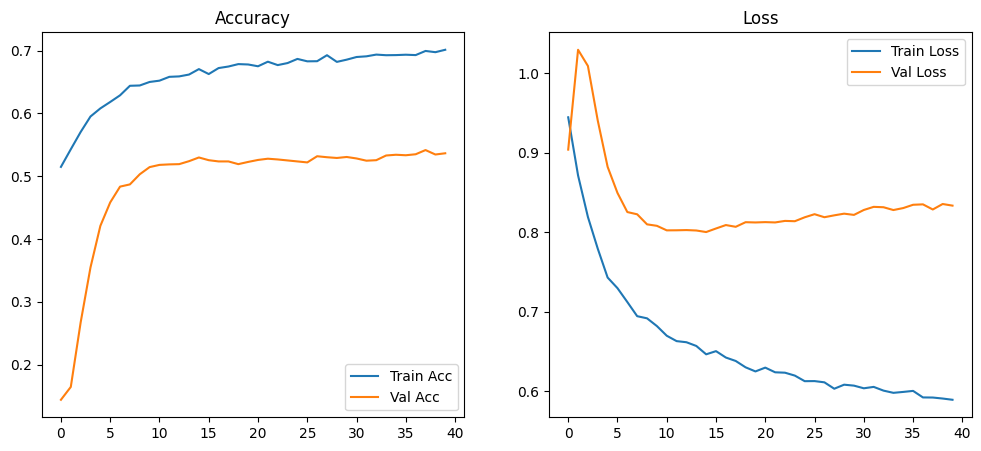

In [16]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()